In [1]:
%matplotlib inline

# Question 1: Quantum natural gradient

[Stokes et al. (2019)](https://arxiv.org/abs/1909.02108).

## Background

The most successful class of quantum algorithms for use on near-term noisy quantum hardware is the so-called variational quantum algorithm. As laid out in the, in variational quantum algorithms a low-depth parametrized quantum circuit ansatz is chosen, and a problem-specific observable measured. A classical optimization loop is then used to find the set of quantum parameters that *minimize* a particular measurement expectation value of the quantum device. Examples of such algorithms include the variational quantum
eigensolver (VQE).

Most recent demonstrations of variational quantum algorithms have used gradient-free classical optimization methods, such as the Nelder-Mead algorithm. However, the parameter-shift rule (as implemented in PennyLane) allows the user to automatically compute analytic gradients of quantum circuits. This opens up the possibility to train quantum computing hardware using gradient descent\-\--the same method used to train deep learning models. Though one caveat has surfaced with gradient descent \-\-- how do we choose the optimal step size for our variational quantum algorithms, to ensure successful and efficient optimization?

### The natural gradient

In standard gradient descent, each optimization step is given by

$$\theta_{t+1} = \theta_t -\eta \nabla \mathcal{L}(\theta),$$

where $\mathcal{L}(\theta)$ is the cost as a function of the parameters $\theta$, and $\eta$ is the learning rate or step size. In essence, each optimization step calculates the steepest descent direction around the local value of $\theta_t$ in the parameter space, and updates $\theta_t\rightarrow \theta_{t+1}$ by this vector.

The problem with the above approach is that each optimization step is strongly connected to a *Euclidean geometry* on the parameter space. The parametrization is not unique, and different parametrizations can distort distances within the optimization landscape.

Performing gradient descent in the $(\theta_0, \theta_1)$ parameter space, we are updating each parameter by the same Euclidean distance, and not taking into account the fact that the cost function might vary at a different rate with respect to each parameter.

Instead, if we perform a change of coordinate system (re-parametrization) of the cost function, we might find a parameter space where variations in $\mathcal{L}$ are similar across different parameters. This is the case with the new parametrization $(\phi_0, \phi_1)$; the cost function is unchanged, but we now have a nicer geometry in which to perform gradient descent, and a more informative stepsize. This leads to faster convergence, and can help avoid optimization becoming stuck in local minima. For a more in-depth explanation, including why the parameter space might not be best represented by a Euclidean space, see [Yamamoto (2019)](https://arxiv.org/abs/1909.05074).

However, what if we avoid gradient descent in the parameter space altogether? If we instead consider the optimization problem as a probability distribution of possible output values given an input (i.e.,[maximum likelihood estimation](https://en.wikipedia.org/wiki/Likelihood_function)), a better approach is to perform the gradient descent in the *distribution space*, which is dimensionless and invariant with respect to the parametrization. As a result, each optimization step will always choose the optimum step-size for every parameter, regardless of the parametrization.

In classical neural networks, the above process is known as *natural gradient descent*, and was first introduced by [Amari(1998)](https://www.mitpressjournals.org/doi/abs/10.1162/089976698300017746).

The standard gradient descent is modified as follows:

$$\theta_{t+1} = \theta_t - \eta F^{-1}\nabla \mathcal{L}(\theta),$$

where $F$ is the [Fisher information matrix](https://en.wikipedia.org/wiki/Fisher_information#Matrix_form). The Fisher information matrix acts as a metric tensor, transforming the steepest descent in the Euclidean parameter space to the steepest descent in the distribution space.

### The quantum analog

In a similar vein, it has been shown that the standard Euclidean
geometry is sub-optimal for optimization of quantum variational
algorithms [(Harrow and Napp, 2019)](https://arxiv.org/abs/1901.05374).
The space of quantum states instead possesses a unique invariant metric
tensor known as the Fubini-Study metric tensor $g_{ij}$, which can be
used to construct a quantum analog to natural gradient descent:

$$\theta_{t+1} = \theta_t - \eta g^{+}(\theta_t)\nabla \mathcal{L}(\theta),$$

where $g^{+}$ refers to the pseudo-inverse.

It can be shown that the Fubini-Study metric tensor reduces to the Fisher information matrix in the classical limit.

Furthermore, in the limit where $\eta\rightarrow 0$, the dynamics of the system are equivalent to imaginary-time evolution within the variational subspace, as proposed in [McArdle et al. (2018)](https://arxiv.org/abs/1804.03023).



### Block-diagonal metric tensor


A block-diagonal approximation to the Fubini-Study metric tensor of a variational quantum circuit can be evaluated on quantum hardware.

Consider a variational quantum circuit

$$U(\mathbf{\theta})|\psi_0\rangle = V_L(\theta_L) W_L V_{L-1}(\theta_{L-1}) W_{L-1}
  \cdots V_{\ell}(\theta_{\ell}) W_{\ell} \cdots V_{0}(\theta_{0}) W_{0} |\psi_0\rangle$$

where

-   $|\psi_0\rangle$ is the initial state,
-   $W_\ell$ are layers of non-parametrized quantum gates,
-   $V_\ell(\theta_\ell)$ are layers of parametrized quantum gates with
    $n_\ell$ parameters
    $\theta_\ell = \{\theta^{(\ell)}_0, \dots, \theta^{(\ell)}_n\}$.

Further, assume all parametrized gates can be written in the form $X(\theta^{(\ell)}_{i}) = e^{i\theta^{(\ell)}_{i} K^{(\ell)}_i}$, where $K^{(\ell)}_i$ is the *generator* of the parametrized operation.

For each parametric layer $\ell$ in the variational quantum circuit the $n_\ell\times n_\ell$ block-diagonal submatrix of the Fubini-Study tensor $g_{ij}^{(\ell)}$ is calculated by:

$$g_{ij}^{(\ell)} = \langle \psi_{\ell-1} | K_i K_j | \psi_{\ell-1} \rangle
- \langle \psi_{\ell-1} | K_i | \psi_{\ell-1}\rangle
\langle \psi_{\ell-1} |K_j | \psi_{\ell-1}\rangle$$

where

$$| \psi_{\ell-1}\rangle = V_{\ell-1}(\theta_{\ell-1}) W_{\ell-1} \cdots V_{0}(\theta_{0}) W_{0} |\psi_0\rangle.$$

(that is, $|\psi_{\ell-1}\rangle$ is the quantum state prior to the
application of parameterized layer $\ell$), and we have
$K_i \equiv K_i^{(\ell)}$ for brevity.



## Tasks

PennyLane provides an implementation of the quantum natural gradient optimizer, `~.pennylane.QNGOptimizer`.


### Task 1
Compare the optimization convergence of the QNG Optimizer and the `~.pennylane.GradientDescentOptimizer` for the simple single qubit VQE. Visualize the difference for at least 500 optimization steps


In [2]:
import matplotlib.pyplot as plt
from pennylane import numpy as np
import pennylane as qml

For this simple example, we consider the following single-qubit
Hamiltonian: $\sigma_x + \sigma_z$.

We define the device:


In [3]:
dev = qml.device("default.qubit", wires=1)

For the variational ansatz, we use two single-qubit rotations.


In [4]:
def circuit(params, wires=0):
    qml.RX(params[0], wires=wires)
    qml.RY(params[1], wires=wires)

We then define our cost function which supports the computation of block-diagonal or diagonal approximations to the Fubini-Study metric tensor. This tensor is a crucial component for optimizing with quantum
natural gradients.


In [5]:
coeffs = [1, 1]
obs = [qml.PauliX(0), qml.PauliZ(0)]

H = qml.Hamiltonian(coeffs, obs)

@qml.qnode(dev)
def cost_fn(params):
    circuit(params)
    return qml.expval(H)

To analyze the performance of quantum natural gradient on VQE calculations, we set up and execute optimizations using the
`GradientDescentOptimizer` (which does not utilize quantum gradients) and the `QNGOptimizer` that uses the block-diagonal approximation to the
metric tensor.

To perform a fair comparison, we fix the initial parameters for the two optimizers.


In [6]:
init_params = np.array([3.97507603, 3.00854038], requires_grad=True)

We will carry out each optimization over a maximum of 500 steps. As was
done in the VQE tutorial, we aim to reach a convergence tolerance of
around $10^{-6}$. We use a step size of 0.01.


In [7]:
max_iterations = 500
conv_tol = 1e-06
step_size = 0.01


### Task 2

Repeat the same comparison for Hydrogen VQE.

To construct our system Hamiltonian, we first read the molecular geometry from the external file. Create a file called "h2.xyz" with content

   2
   in Angstrom
   H          0.00000        0.00000       -0.35000
   H          0.00000        0.00000        0.35000

using the `~.pennylane.qchem.read_structure` function. The molecular Hamiltonian is then built using the `~.pennylane.qchem.molecular_hamiltonian`
function.


In [8]:
geo_file = "files/h2.xyz"

symbols, coordinates = qml.qchem.read_structure(geo_file)
hamiltonian, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates)

print("Number of qubits = ", qubits)

Number of qubits =  4


In [9]:
dev = qml.device("default.qubit", wires=qubits)
hf_state = np.array([1, 1, 0, 0], requires_grad=False)

def ansatz(params, wires=[0, 1, 2, 3]):
    qml.BasisState(hf_state, wires=wires)
    for i in wires:
        qml.RZ(params[3 * i], wires=i)
        qml.RY(params[3 * i + 1], wires=i)
        qml.RZ(params[3 * i + 2], wires=i)
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[2, 0])
    qml.CNOT(wires=[3, 1])

Note that the qubit register has been initialized to $|1100\rangle$, which encodes for the Hartree-Fock state of the hydrogen molecule described in the minimal basis. Again, we define the cost function to be the following QNode that measures `expval(H)`:


In [10]:
@qml.qnode(dev)
def cost(params):
    ansatz(params)
    return qml.expval(hamiltonian)

For this problem, we can compute the exact value of the ground state energy via exact diagonalization. The value is below.


In [11]:
exact_value = -1.136189454088

For optimizations runs, you need to enable differentiability in Hamiltonian for gradient descent


In [12]:
np.random.seed(0)
init_params = np.random.uniform(low=0, high=2 * np.pi, size=12, requires_grad=True)
max_iterations = 500
step_size = 0.5
conv_tol = 1e-06

and make the Hamiltonian coefficients non-differentiable by setting
`requires_grad=False`. for Quantum natural gradients


In [13]:
hamiltonian = qml.Hamiltonian(np.array(hamiltonian.coeffs, requires_grad=False), hamiltonian.ops)



### Task 3

Robustness in parameter initialization

While results above show a more rapid convergence for quantum natural gradients, what if we were just lucky, i.e., we started at a \"good\" point in parameter space? How do we know this will be the case with high
probability regardless of the parameter initialization?

Using the same system Hamiltonian, ansatz, and device, try 10 independent trials with random parameter initializations.

## Note

While using QNG may help accelerate the VQE algorithm in terms of optimization steps, each QNG step is more costly than its vanilla gradient descent counterpart due to a greater number of calls to the
quantum computer that are needed to compute the Fubini-Study metric tensor.

Further benchmark studies are needed to better understand the advantages of quantum natural gradient, preliminary studies such as this tutorial show the potentials of the method.


# Question 2: Quantum transfer learning

Details on this topic can be found in the research paper ([Mari et al. (2019)](https://arxiv.org/abs/1912.08278)).

## Background

Transfer learning is a well-established technique for training artificial neural networks. The idea is based on the general intuition that if a pre-trained network is good at solving a given problem, then, with just a bit of additional training, it can be used to also solve a different but related problem.

This idea can be formalized in terms of two abstract networks $A$ and $B$, independently from their quantum or classical physical nature.

**general definition of the transfer learning method**:

1.  Take a network $A$ that has been pre-trained on a dataset $D_A$ and
    for a given task $T_A$.
2.  Remove some of the final layers. In this way, the resulting
    truncated network $A'$ can be used as a feature extractor.
3.  Connect a new trainable network $B$ at the end of the pre-trained
    network $A'$.
4.  Keep the weights of $A'$ constant, and train the final block $B$
    with a new dataset $D_B$ and/or for a new task of interest $T_B$.


### Classical-to-quantum transfer learning


We focus on the CQ transfer learning scheme discussed in the previous
section and we give a specific example.

1.  As pre-trained network $A$ we use **ResNet18**, a deep residual
    neural network introduced by Microsoft in Ref. \[3\], which is
    pre-trained on the *ImageNet* dataset.
2.  After removing its final layer we obtain $A'$, a pre-processing
    block which maps any input high-resolution image into 512 abstract
    features.
3.  Such features are classified by a 4-qubit \"dressed quantum
    circuit\" $B$, i.e., a variational quantum circuit sandwiched
    between two classical layers.
4.  The hybrid model is trained, keeping $A'$ constant, on the
    *Hymenoptera* dataset (a small subclass of ImageNet) containing
    images of *ants* and *bees*.



### General setup

To use the PyTorch interface in PennyLane, you must first [install
PyTorch](https://pytorch.org/get-started/locally/#start-locally).
:::

In addition to *PennyLane*, we will also need some standard *PyTorch*
libraries and the plotting library *matplotlib*.


In [14]:
# Some parts of this code are based on the Python script:
# https://github.com/pytorch/tutorials/blob/master/beginner_source/transfer_learning_tutorial.py
# License: BSD

import time
import os
import copy

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms

# Pennylane
import pennylane as qml
from pennylane import numpy as np

torch.manual_seed(42)
np.random.seed(42)

# Plotting
import matplotlib.pyplot as plt

# OpenMP: number of parallel threads.
os.environ["OMP_NUM_THREADS"] = "1"

### Setting of the main hyper-parameters of the model


Note

First try with `num_epochs=1` and, if everything runs smoothly, increase it to a larger value.


In [15]:
n_qubits = 4                # Number of qubits
step = 0.0004               # Learning rate
batch_size = 4              # Number of samples for each training step
num_epochs = 3              # Number of training epochs
q_depth = 6                 # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 0.1    # Learning rate reduction applied every 10 epochs.
q_delta = 0.01              # Initial spread of random quantum weights
start_time = time.time()    # Start of the computation timer

We initialize a PennyLane device with a `default.qubit` backend.


In [16]:
dev = qml.device("default.qubit", wires=n_qubits)

We configure PyTorch to use CUDA only if available. Otherwise the CPU is
used.


In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Dataset loading


The dataset containing images of *ants* and *bees* can be downloaded
[here](https://download.pytorch.org/tutorial/hymenoptera_data.zip) and
should be extracted in the subfolder `_data/hymenoptera_data`.

This is a very small dataset (roughly 250 images), too small for
training from scratch a classical or quantum model, however it is enough
when using *transfer learning* approach.

The PyTorch packages `torchvision` and `torch.utils.data` are used for
loading the dataset and performing standard preliminary image
operations: resize, center, crop, normalize, *etc.*


In [20]:
data_transforms = {
    "train": transforms.Compose(
        [
            # transforms.RandomResizedCrop(224),     # uncomment for data augmentation
            # transforms.RandomHorizontalFlip(),     # uncomment for data augmentation
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            # Normalize input channels using mean values and standard deviations of ImageNet.
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

data_dir = "data/hymenoptera_data"
image_datasets = {
    x if x == "train" else "validation": datasets.ImageFolder(
        os.path.join(data_dir, x), data_transforms[x]
    )
    for x in ["train", "val"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "validation"]}
class_names = image_datasets["train"].classes

# Initialize dataloader
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "validation"]
}

# function to plot images
def imshow(inp, title=None):
    """Display image from tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # Inverse of the initial normalization operation.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

Let us show a batch of the test data, just to have an idea of the
classification problem.


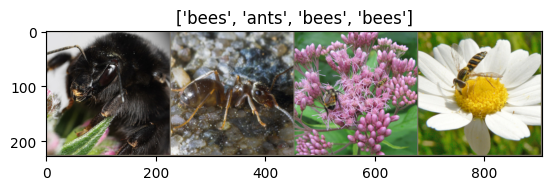

In [21]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders["validation"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "validation"]
}

### Variational quantum circuit


We first define some quantum layers that will compose the quantum
circuit.


In [22]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)


def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)


def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    # CNOT  CNOT  CNOT  CNOT...  CNOT
    #   CNOT  CNOT  CNOT...  CNOT
    for i in range(0, nqubits - 1, 2):  # Loop over even indices: i=0,2,...N-2
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):  # Loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])

Now we define the quantum circuit through the PennyLane [qnode] decorator .

The structure is that of a typical variational quantum circuit:

-   **Embedding layer:** All qubits are first initialized in a balanced
    superposition of *up* and *down* states, then they are rotated
    according to the input parameters (local embedding).
-   **Variational layers:** A sequence of trainable rotation layers and
    constant entangling layers is applied.
-   **Measurement layer:** For each qubit, the local expectation value
    of the $Z$ operator is measured. This produces a classical output
    vector, suitable for additional post-processing.


In [23]:
@qml.qnode(dev, interface="torch")
def quantum_net(q_input_features, q_weights_flat):
    """
    The variational quantum circuit.
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)

    # Embed features in the quantum node
    RY_layer(q_input_features)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k])

    # Expectation values in the Z basis
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)

### Dressed quantum circuit

We can now define a custom `torch.nn.Module` representing a *dressed*
quantum circuit.

This is a concatenation of:

-   A classical pre-processing layer (`nn.Linear`).
-   A classical activation function (`torch.tanh`).
-   A constant `np.pi/2.0` scaling.
-   The previously defined quantum circuit (`quantum_net`).
-   A classical post-processing layer (`nn.Linear`).

The input of the module is a batch of vectors with 512 real parameters
(features) and the output is a batch of vectors with two real outputs
(associated with the two classes of images: *ants* and *bees*).


In [24]:
class DressedQuantumNet(nn.Module):
    """
    Torch module implementing the *dressed* quantum net.
    """

    def __init__(self):
        """
        Definition of the *dressed* layout.
        """

        super().__init__()
        self.pre_net = nn.Linear(512, n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits, 2)

    def forward(self, input_features):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """

        # obtain the input features for the quantum circuit
        # by reducing the feature dimension from 512 to 4
        pre_out = self.pre_net(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = quantum_net(elem, self.q_params).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        # return the two-dimensional prediction from the postprocessing layer
        return self.post_net(q_out)

### Hybrid classical-quantum model


We are finally ready to build our full hybrid classical-quantum network.
We follow the *transfer learning* approach:

1.  First load the classical pre-trained network *ResNet18* from the
    `torchvision.models` zoo.
2.  Freeze all the weights since they should not be trained.
3.  Replace the last fully connected layer with our trainable dressed
    quantum circuit (`DressedQuantumNet`).


The *ResNet18* model is automatically downloaded by PyTorch and it may take several minutes (only the first time).


In [25]:
model_hybrid = torchvision.models.resnet18(pretrained=True)

for param in model_hybrid.parameters():
    param.requires_grad = False


# Notice that model_hybrid.fc is the last layer of ResNet18
model_hybrid.fc = DressedQuantumNet()

# Use CUDA or CPU according to the "device" object.
model_hybrid = model_hybrid.to(device)

/home/obm/Prog/miniconda3/envs/pennylane/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/obm/Prog/miniconda3/envs/pennylane/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/obm/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
52.5%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable


### Training and results

Before training the network we need to specify the *loss* function.

We use, as usual in classification problem, the *cross-entropy* which is
directly available within `torch.nn`.


In [26]:
criterion = nn.CrossEntropyLoss()

We also initialize the *Adam optimizer* which is called at each training
step in order to update the weights of the model.


In [27]:
optimizer_hybrid = optim.Adam(model_hybrid.fc.parameters(), lr=step)

We schedule to reduce the learning rate by a factor of
`gamma_lr_scheduler` every 10 epochs.


In [28]:
exp_lr_scheduler = lr_scheduler.StepLR(
    optimizer_hybrid, step_size=10, gamma=gamma_lr_scheduler
)

What follows is a training function that will be called later. This
function should return a trained model that can be used to make
predictions (classifications).


In [29]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 10000.0  # Large arbitrary number
    best_acc_train = 0.0
    best_loss_train = 10000.0  # Large arbitrary number
    print("Training started:")

    for epoch in range(num_epochs):

        # Each epoch has a training and validation phase
        for phase in ["train", "validation"]:
            if phase == "train":
                # Set model to training mode
                model.train()
            else:
                # Set model to evaluate mode
                model.eval()
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            n_batches = dataset_sizes[phase] // batch_size
            it = 0
            for inputs, labels in dataloaders[phase]:
                since_batch = time.time()
                batch_size_ = len(inputs)
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                # Track/compute gradient and make an optimization step only when training
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # Print iteration results
                running_loss += loss.item() * batch_size_
                batch_corrects = torch.sum(preds == labels.data).item()
                running_corrects += batch_corrects
                print(
                    "Phase: {} Epoch: {}/{} Iter: {}/{} Batch time: {:.4f}".format(
                        phase,
                        epoch + 1,
                        num_epochs,
                        it + 1,
                        n_batches + 1,
                        time.time() - since_batch,
                    ),
                    end="\r",
                    flush=True,
                )
                it += 1

            # Print epoch results
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            print(
                "Phase: {} Epoch: {}/{} Loss: {:.4f} Acc: {:.4f}        ".format(
                    "train" if phase == "train" else "validation  ",
                    epoch + 1,
                    num_epochs,
                    epoch_loss,
                    epoch_acc,
                )
            )

            # Check if this is the best model wrt previous epochs
            if phase == "validation" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "validation" and epoch_loss < best_loss:
                best_loss = epoch_loss
            if phase == "train" and epoch_acc > best_acc_train:
                best_acc_train = epoch_acc
            if phase == "train" and epoch_loss < best_loss_train:
                best_loss_train = epoch_loss
      
            # Update learning rate
            if phase == "train":
                scheduler.step()

    # Print final results
    model.load_state_dict(best_model_wts)
    time_elapsed = time.time() - since
    print(
        "Training completed in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60)
    )
    print("Best test loss: {:.4f} | Best test accuracy: {:.4f}".format(best_loss, best_acc))
    return model

We are ready to perform the actual training process.


In [30]:
model_hybrid = train_model(
    model_hybrid, criterion, optimizer_hybrid, exp_lr_scheduler, num_epochs=num_epochs
)

Training started:
Phase: train Epoch: 1/3 Loss: 0.6993 Acc: 0.5246        
Phase: validation   Epoch: 1/3 Loss: 0.6432 Acc: 0.6536        
Phase: train Epoch: 2/3 Loss: 0.6141 Acc: 0.7049        
Phase: validation   Epoch: 2/3 Loss: 0.5392 Acc: 0.8235        
Phase: train Epoch: 3/3 Loss: 0.5652 Acc: 0.7336        
Phase: validation   Epoch: 3/3 Loss: 0.4484 Acc: 0.8497        
Training completed in 0m 40s
Best test loss: 0.4484 | Best test accuracy: 0.8497


### Visualizing the model predictions



We first define a visualization function for a batch of test data.


In [31]:
def visualize_model(model, num_images=6, fig_name="Predictions"):
    images_so_far = 0
    _fig = plt.figure(fig_name)
    model.eval()
    with torch.no_grad():
        for _i, (inputs, labels) in enumerate(dataloaders["validation"]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                ax.set_title("[{}]".format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    return

Finally, we can run the previous function to see a batch of images with
the corresponding predictions.


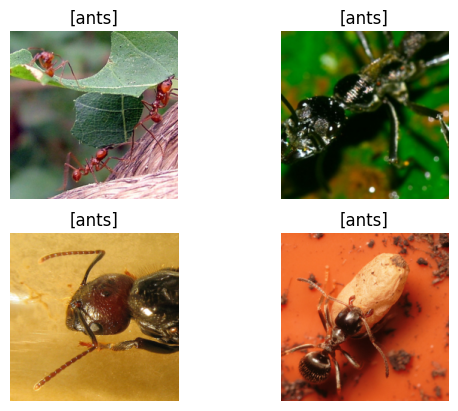

In [32]:
visualize_model(model_hybrid, num_images=batch_size)
plt.show()

## Tasks

### Task 1

Try to create your own classifier on two classes of images, for example, you could collect 20-30 photos of a cat and another cat and train a model to classify the two cats. This would be a good way to practice creating a dataset as well as building a model on that dataset. Tip: You can convert jet data obtained in CERN to images, and do classification on them.

### Task 2

Get the "most wrong" of the predictions on the test dataset (any you used) and plot the 5 "most wrong" images. You can do this by:

* Predicting across all of the test dataset, storing the labels and predicted probabilities.
* Sort the predictions by wrong prediction and then descending predicted probabilities, this will give you the wrong predictions with the highest prediction probabilities, in other words, the "most wrong".
* Plot the top 5 "most wrong" images, why do you think the model got these wrong?
